In [1]:
# Author: Diego Cussen
# Description: Mixed logit model simulation. Two retailers, two suppliers, full network.
# Use Conlon and Gortmaker's (2020) pyBLP 
# output: figure 1 in the main body of the paper

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyblp

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

'1.1.0'

The model. 

Let $I=J=2$, $G=\{(11), (12),(21),(22)\}$. Each supplier sells one input to each retailer, who is an intermediary. Suppliers sell different inputs and have zero marginal cost. Consumers are not one-stop shoppers. 

Suppliers and retailers negotiate over a linear input price $x_{ij}$ for unit of input. If they fail to agree, the retailer may buy a substitute from a intermediary wholesaler at a price $\bar{c}_{ij}$ that it cannot negotiate. This outside option is similar to that of Hristakeva (JPE 2022).

Abusing notation, let $i$ index a product sold by retailer $j$ (identical to the supplier it buys the input from). Retailers' only costs are those of purchasing the inputs at linear input proce $x_{ij}$. Then, on and off-path profits are

$$ \hat{\pi}_{D_j} (x_{ij}, \mathbf{x}_{-(ij)}) = \sum_{i=1, 2} (p_{ij}-x_{ij}) \cdot s_{ij}(\mathbf{p}) $$

$$ \bar{\pi}_{D_j} (\mathbf{x}_{-(ij)}) = (p_{ij}- \bar{c}_{ij}) \cdot s_{ij}(\mathbf{p^{off}}) + (p_{-ij}-x_{-ij}) \cdot s_{-ij}(\mathbf{p^{off}}) $$

$$ \hat{\pi}_{U_i} (\mathbf{x}_{ij}, \mathbf{x}_{-(ij)}) = \sum_{j=1, 2} x_{ij} \cdot s_{ij}(\mathbf{p}) $$

$$ \bar{\pi}_{U_i} (\mathbf{x}_{-(ij)}) = x_{i-j} \cdot s_{i-j}(\mathbf{p^{off}}) $$

where $p, \, p^{off}\in P\subset \mathbb{R}^4$ compact and convex, and 

$$ X \equiv \prod_{(ij)\in G}[0,\bar{c}_{ij}]$$

With $b_{ij}\in (0,1)$ for all $(ij)$, this $X$ ensures that $F$ maps into the interior of $X$. Therefore, Assumptions 1, 2.1, 3.1 and 3.3 are satisfied. As argued in the paper, the definition of $X$ above is an alternative to Assumption 3.4. So, all that remains for the equilibrium to be locally unique is checking that Assumptions 2.2, 2.3 and 3.2 hold. Remembering that A2.2 can be considerably weaked (Appendix B), and that A3.2 is almost guaranteed to hold, the main concern is Assumption 2.3. I check it below.

Bargaining power parameters are $b_{ij}\in[0,1]$ for all $(ij)$. I define them by drawing $b_f$ from a uniform distribution in $[0,1]$ for every firm $f$, and then defining $b_{ij} := b_j/(b_i +b_j)$.


In [2]:
# parameters. one market: T = 1
L = 4   # number of products == number of contract terms

In [4]:
# generate the necessary random values.
np.random.seed(1987)

# bargaining power parameters
b_f = np.random.uniform(0,1,L) 
b_11 = b_f[0]/(b_f[0]+b_f[2])
b_21 = b_f[0]/(b_f[0]+b_f[3])
b_12 = b_f[1]/(b_f[1]+b_f[2])
b_22 = b_f[1]/(b_f[1]+b_f[3])
b = np.array([b_11, b_21, b_12, b_22])

print("Bargaining power parameters: ", b)

Bargaining power parameters:  [0.24422219 0.23799849 0.08882901 0.08611411]


In [5]:
# X grid
# assume \bar{c}_{ij} = 0.5 for all (ij)
c_bar = 0.5
x_min = 0
steps = 54

X_11 = np.linspace(x_min,c_bar,steps).reshape(1,steps)
X_21 = np.linspace(x_min,c_bar,steps).reshape(1,steps)
X_12 = np.linspace(x_min,c_bar,steps).reshape(1,steps)
X_22 = np.linspace(x_min,c_bar,steps).reshape(1,steps)

X = np.row_stack([X_11,X_21,X_12,X_22])
print(X.shape)

(4, 54)


In [6]:
# initial price vector guess
p_init = [1,1,1,1]

In [7]:
# pyBLP simulation example. Following the tutorial in  https://pyblp.readthedocs.io/en/stable/tutorial.html
id_data = pyblp.build_id_data(T=1, J=4, F=2)

In [8]:
integration = pyblp.Integration('product', 9)
integration

Configured to construct nodes and weights according to the level-9 Gauss-Hermite product rule with options {}.

In [9]:
simulation = pyblp.Simulation(
   product_formulations=(
       pyblp.Formulation('1 + prices + x'),
       pyblp.Formulation('0 + x'),
       pyblp.Formulation('0 + z')
   ),
   beta=[1, -2, 2],
   sigma=1,
   gamma=[0],
   product_data=id_data,
   integration=integration,
   seed=0
)
simulation

Dimensions:
 T    N    F    I    K1    K2    K3 
---  ---  ---  ---  ----  ----  ----
 1    4    2    9    3     1     1  

Formulations:
        Column Indices:           0     1      2 
-------------------------------  ---  ------  ---
  X1: Linear Characteristics      1   prices   x 
 X2: Nonlinear Characteristics    x              
X3: Linear Cost Characteristics   z              

Nonlinear Coefficient True Values:
Sigma:     x    
------  --------
  x     +1.0E+00

Beta True Values:
   1       prices      x    
--------  --------  --------
+1.0E+00  -2.0E+00  +2.0E+00

Gamma True Values:
   z    
--------
+0.0E+00

In [10]:
# compute all equilibrium prices and market shares
eqm_prices_matrix = np.zeros((L,steps**L))
eqm_shares_matrix = np.zeros((L,steps**L))

counter = 0
for q in range(steps):
    x_11 = X[0,q]
    for r in range(steps):
        x_21 = X[1,r]
        for s in range(steps):
            x_12 = X[2,s]
            for t in range(steps):
                x_22 = X[3,t]
                marg_cost = np.array([x_11, x_21, x_12, x_22]).reshape(L,1)
                simulation_results = simulation.replace_endogenous(costs=marg_cost, prices=p_init)
                
                eqm_prices_matrix[:,counter] = simulation_results.product_data['prices'].reshape(L,) 
                eqm_shares_matrix[:,counter] = simulation_results.product_data['shares'].reshape(L,) 
                if counter % 50000 == 0:
                    print(counter)
                counter +=1

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
900000
950000
1000000
1050000
1100000
1150000
1200000
1250000
1300000
1350000
1400000
1450000
1500000
1550000
1600000
1650000
1700000
1750000
1800000
1850000
1900000
1950000
2000000
2050000
2100000
2150000
2200000
2250000
2300000
2350000
2400000
2450000
2500000
2550000
2600000
2650000
2700000
2750000
2800000
2850000
2900000
2950000
3000000
3050000
3100000
3150000
3200000
3250000
3300000
3350000
3400000
3450000
3500000
3550000
3600000
3650000
3700000
3750000
3800000
3850000
3900000
3950000
4000000
4050000
4100000
4150000
4200000
4250000
4300000
4350000
4400000
4450000
4500000
4550000
4600000
4650000
4700000
4750000
4800000
4850000
4900000
4950000
5000000
5050000
5100000
5150000
5200000
5250000
5300000
5350000
5400000
5450000
5500000
5550000
5600000
5650000
5700000
5750000
5800000
5850000
5900000
5950000
6000000
6050000
6100000
6150000
6200000
6250000
6300000
6350000
64

In [11]:
# check
print(eqm_prices_matrix)
print(eqm_shares_matrix)

[[0.72213253 0.72302057 0.72391061 ... 1.17418061 1.17489316 1.1756073 ]
 [0.69095987 0.69177112 0.69258467 ... 1.14553278 1.14615206 1.14677296]
 [1.29427118 1.28971114 1.28517454 ... 1.68765132 1.68317679 1.67872682]
 [1.30159546 1.30638149 1.31119068 ... 1.66533884 1.67025246 1.67519047]]
[[0.24945643 0.25019817 0.25094021 ... 0.2025701  0.20320899 0.20384819]
 [0.03237785 0.0324852  0.03259267 ... 0.02522006 0.02530564 0.0253913 ]
 [0.07979242 0.08091163 0.08204241 ... 0.07211437 0.07309812 0.07409129]
 [0.53398007 0.53148755 0.52898064 ... 0.50362531 0.50101108 0.49838373]]


In [12]:
# on and off-path profits and ourside option market shares
on_path_profit_D1 = np.zeros((steps,steps,steps,steps))
on_path_profit_D2 = np.zeros((steps,steps,steps,steps))
on_path_profit_U1 = np.zeros((steps,steps,steps,steps))
on_path_profit_U2 = np.zeros((steps,steps,steps,steps))

off_path_profit_D1_11 = np.zeros((steps,steps,steps,steps))
off_path_profit_D1_21 = np.zeros((steps,steps,steps,steps))

off_path_profit_D2_12 = np.zeros((steps,steps,steps,steps))
off_path_profit_D2_22 = np.zeros((steps,steps,steps,steps))

off_path_profit_U1_11 = np.zeros((steps,steps,steps,steps))
off_path_profit_U1_12 = np.zeros((steps,steps,steps,steps))

off_path_profit_U2_21 = np.zeros((steps,steps,steps,steps))
off_path_profit_U2_22 = np.zeros((steps,steps,steps,steps))

U1_11_outside_option_shares = np.zeros((1,steps,steps,steps))

U2_21_outside_option_shares = np.zeros((steps,1,steps,steps))

U1_12_outside_option_shares = np.zeros((steps,steps,1,steps))

U2_22_outside_option_shares = np.zeros((steps,steps,steps,1))


In [13]:
# all on-path profits
counter = 0
for q in range(steps):
    x_11 = X[0,q]
    for r in range(steps):
        x_21 = X[1,r]
        for s in range(steps):
            x_12 = X[2,s]
            for t in range(steps):
                x_22 = X[3,t]
                p_11, p_21, p_12, p_22 = eqm_prices_matrix[:,counter]
                s_11, s_21, s_12, s_22 = eqm_shares_matrix[:,counter]

                on_path_profit_D1[q,r,s,t] = (p_11-x_11)*s_11 + (p_21-x_21)*s_21
                on_path_profit_U1[q,r,s,t] = x_11*s_11 + x_12*s_12
                
                on_path_profit_D2[q,r,s,t] = (p_12-x_12)*s_12 + (p_22-x_22)*s_22
                on_path_profit_U2[q,r,s,t] = x_21*s_21 + x_22*s_22
                
                # get the outside option shares
                if q == steps-1: 
                    U1_11_outside_option_shares[0,r,s,t] = s_12
                    
                if r == steps-1: 
                    U2_21_outside_option_shares[q,0,s,t] = s_22
                    
                if s == steps-1:
                    U1_12_outside_option_shares[q,r,0,t] = s_11
                
                if t == steps-1:
                    U2_22_outside_option_shares[q,r,s,0] = s_21
                
                counter +=1

In [14]:
# off-path profits 
for q in range(steps):
    x_11 = X[0,q]
    for r in range(steps):
        x_21 = X[1,r]
        for s in range(steps):
            x_12 = X[2,s]
            for t in range(steps):
                x_22 = X[3,t]
                
                # pair (11)
                off_path_profit_D1_11[q,r,s,t] = on_path_profit_D1[steps-1,r,s,t] 
                off_path_profit_U1_11[q,r,s,t] =  x_12 * U1_11_outside_option_shares[0,r,s,t]
                
                # pair (21)
                off_path_profit_D1_21[q,r,s,t] = on_path_profit_D1[q,steps-1,s,t]
                off_path_profit_U2_21[q,r,s,t] = x_22 * U2_21_outside_option_shares[q,0,s,t]
                
                # pair (12)
                off_path_profit_D2_12[q,r,s,t] = on_path_profit_D2[q,r,steps-1,t]
                off_path_profit_U1_12[q,r,s,t] = x_11 * U1_12_outside_option_shares[q,r,0,t]
                
                # pair (22)
                off_path_profit_D2_22[q,r,s,t] = on_path_profit_D2[q,r,s,steps-1]
                off_path_profit_U2_22[q,r,s,t] = x_21 * U2_22_outside_option_shares[q,r,s,0]


In [15]:
# test
print(np.isnan(on_path_profit_D1).any())
print(np.isnan(on_path_profit_D2).any())
print(np.isnan(on_path_profit_U1).any())
print(np.isnan(on_path_profit_U2).any())

print(np.isnan(off_path_profit_D1_11).any())
print(np.isnan(off_path_profit_U1_11).any())
print(np.isnan(off_path_profit_D1_21).any())
print(np.isnan(off_path_profit_U2_21).any())

print(np.isnan(off_path_profit_D2_12).any())
print(np.isnan(off_path_profit_U1_12).any())
print(np.isnan(off_path_profit_D2_22).any())
print(np.isnan(off_path_profit_U2_22).any())

False
False
False
False
False
False
False
False
False
False
False
False


In [16]:
# nash product functions using vectorization

Nash_product_values_11 = np.zeros((steps,steps,steps,steps))
Nash_product_values_21 = np.zeros((steps,steps,steps,steps))
Nash_product_values_12 = np.zeros((steps,steps,steps,steps))
Nash_product_values_22 = np.zeros((steps,steps,steps,steps))

Nash_product_values_11 = ((np.maximum((on_path_profit_D1 - off_path_profit_D1_11),0))**b_11) * (np.maximum((on_path_profit_U1 - off_path_profit_U1_11),0))**(1-b_11)
Nash_product_values_21 = ((np.maximum((on_path_profit_D1 - off_path_profit_D1_21),0))**b_21) * (np.maximum((on_path_profit_U2 - off_path_profit_U2_21),0))**(1-b_21)
Nash_product_values_12 = ((np.maximum((on_path_profit_D2 - off_path_profit_D2_12),0))**b_12) * (np.maximum((on_path_profit_U1 - off_path_profit_U1_12),0))**(1-b_12)
Nash_product_values_22 = ((np.maximum((on_path_profit_D2 - off_path_profit_D2_22),0))**b_22) * (np.maximum((on_path_profit_U2 - off_path_profit_U2_22),0))**(1-b_22)

In [17]:
# check no NaN
print(np.isnan(Nash_product_values_11).any())
print(np.isnan(Nash_product_values_21).any())
print(np.isnan(Nash_product_values_12).any())
print(np.isnan(Nash_product_values_22).any())

False
False
False
False


In [18]:
# check assumptions A2.2 and A2.3
# A2.3 requires unique global argmax. If it is unique, the not all are zeros, so satisfies A2.2

pair_11_satisfies_A23 = True
for r in range(steps):
        for s in range(steps):
            for t in range(steps):
                size_argmax = np.sum(Nash_product_values_11[:,r,s,t] == np.max(Nash_product_values_11[:,r,s,t]))
                satisfies = pair_11_satisfies_A23*(size_argmax == 1)
                pair_11_satisfies_A23 = satisfies
                if (size_argmax == 1) == False:
                    print(r,s,t)
                if (np.isnan(Nash_product_values_11[:,r,s,t]).any() == True):
                    print(r,s,t)

print('Pair (11) satisfies A2.2 and A2.3: ', pair_11_satisfies_A23)

Pair (11) satisfies A2.2 and A2.3:  True


In [19]:
# for pair (21)
pair_21_satisfies_A23 = True
for r in range(steps):
        for s in range(steps):
            for t in range(steps):
                size_argmax = np.sum(Nash_product_values_21[r,:,s,t] == np.max(Nash_product_values_21[r,:,s,t]))
                satisfies = pair_21_satisfies_A23*(size_argmax == 1)
                pair_21_satisfies_A23 = satisfies

print('Pair (21) satisfies A2.3 and A2.3: ', pair_21_satisfies_A23)

Pair (21) satisfies A2.3 and A2.3:  True


In [20]:
# for pair (12)
pair_12_satisfies_A23 = True
for r in range(steps):
        for s in range(steps):
            for t in range(steps):
                size_argmax = np.sum(Nash_product_values_12[r,s,:,t] == np.max(Nash_product_values_12[r,s,:,t]))
                satisfies = pair_12_satisfies_A23*(size_argmax == 1)
                pair_12_satisfies_A23 = satisfies

print('Pair (12) satisfies A2.2 and A2.3: ', pair_12_satisfies_A23)

Pair (12) satisfies A2.2 and A2.3:  True


In [21]:
# for pair (22)
pair_22_satisfies_A23 = True
for r in range(steps):
        for s in range(steps):
            for t in range(steps):
                size_argmax = np.sum(Nash_product_values_22[r,s,t,:] == np.max(Nash_product_values_22[r,s,t,:]))
                satisfies = pair_22_satisfies_A23*(size_argmax == 1)
                pair_22_satisfies_A23 = satisfies

print('Pair (22) satisfies A2.2 and A2.3: ', pair_22_satisfies_A23)

Pair (22) satisfies A2.2 and A2.3:  True


In [22]:
# print all checks at the same time
print('Assumptions 2.2 and 2.3 are satisfied:', pair_11_satisfies_A23*pair_21_satisfies_A23*pair_12_satisfies_A23*pair_22_satisfies_A23)

Assumptions 2.2 and 2.3 are satisfied: True


Now visualize the Nash product functions and get the bargainining solutions.

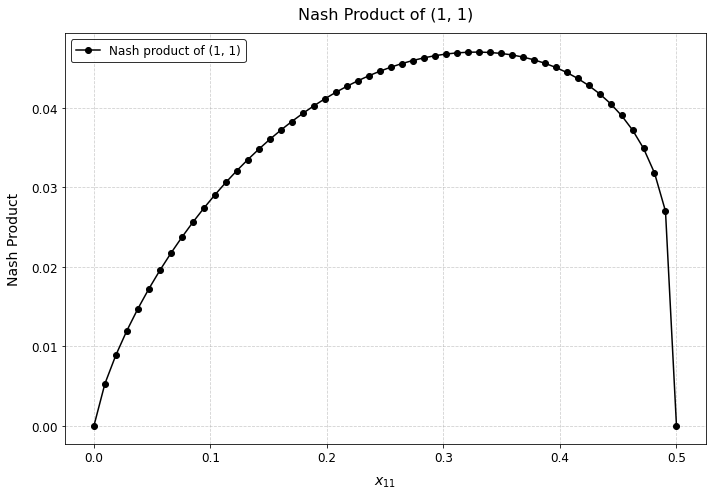

In [23]:
x = X[0,:]
y = Nash_product_values_11[:, 1, 1, 1]

# create plot
plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-', color='black', markersize=6, linewidth=1.5, label='Nash product of (1, 1)')

# format the axes
plt.xlabel(r'$x_{11}$', fontsize=14, labelpad=10)  # Use LaTeX-style formatting
plt.ylabel('Nash Product', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# add title and legend
plt.title('Nash Product of (1, 1)', fontsize=16, pad=15)
plt.legend(fontsize=12, loc='best', frameon=True, edgecolor='black')
plt.grid(visible=True, linestyle='--', alpha=0.6)

# add a border and tighten layout
plt.tight_layout()

# save
plt.savefig('nash_product_11_plot.png', dpi=300, bbox_inches='tight')

# show plot
plt.show()

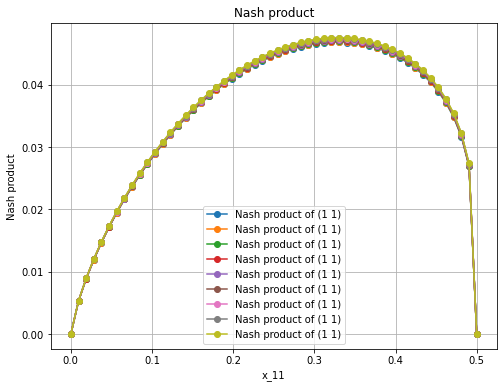

In [24]:
# Nash product of (11)

x = X[0,:]
y = Nash_product_values_11[:,1:10,1,0]
# Plot the points
plt.figure(figsize=(8, 6))
plt.plot(x, y, 'o-', label='Nash product of (1 1)')  # 
plt.xlabel('x_11')
plt.ylabel('Nash product')
plt.title('Nash product')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# bargaining solution of (11)

x_11_star_args = np.zeros((1, steps, steps, steps))
x_11_star = np.zeros((1, steps, steps, steps))

for r in range(steps):
        for s in range(steps):
            for t in range(steps):
                x_11_star_args[0,r,s,t] = np.argmax(Nash_product_values_11[:,r,s,t], axis = 0)
                x_11_star[0,r,s,t] = X[0,int(x_11_star_args[0,r,s,t])]


print(np.max(x_11_star), np.min(x_11_star))
print("w_11 maps to interior of X:", (np.max(x_11_star) < c_bar and np.min(x_11_star) > x_min))
print(np.unique(x_11_star))

0.33962264150943394 0.330188679245283
w_11 maps to interior of X: True
[0.33018868 0.33962264]


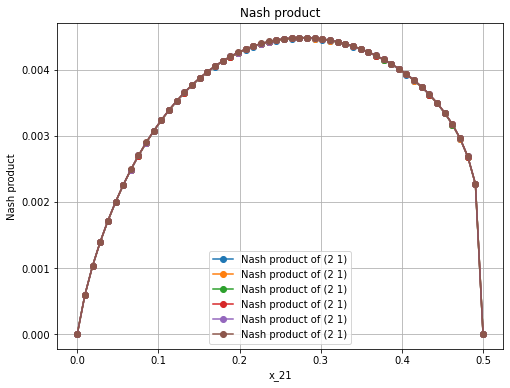

In [26]:
# Nash product of (21)

x = X[1,:]
y = Nash_product_values_21[2,:,1:7,1]
# Plot the points
plt.figure(figsize=(8, 6))
plt.plot(x, y, 'o-', label='Nash product of (2 1)')  # 
plt.xlabel('x_21')
plt.ylabel('Nash product')
plt.title('Nash product')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# bargaining solution of (21)

x_21_star_args = np.zeros((1, steps, steps, steps))
x_21_star = np.zeros((1, steps, steps, steps))

for r in range(steps):
        for s in range(steps):
            for t in range(steps):
                x_21_star_args[0,r,s,t] = np.argmax(Nash_product_values_21[r,:,s,t], axis = 0)
                x_21_star[0,r,s,t] = X[1,int(x_21_star_args[0,r,s,t])]

print(np.max(x_21_star), np.min(x_21_star))
print("w_21 maps to interior of X:", (np.max(x_21_star) < c_bar and np.min(x_21_star) > x_min))
print(np.unique(x_21_star))

0.32075471698113206 0.27358490566037735
w_21 maps to interior of X: True
[0.27358491 0.28301887 0.29245283 0.30188679 0.31132075 0.32075472]


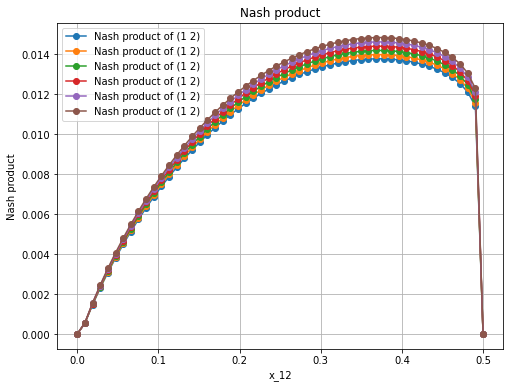

In [28]:
# Nash product of (12)

x = X[2,:]
y = Nash_product_values_12[10,10,:,1:7]
# Plot the points
plt.figure(figsize=(8, 6))
plt.plot(x, y, 'o-', label='Nash product of (1 2)')  # 
plt.xlabel('x_12')
plt.ylabel('Nash product')
plt.title('Nash product')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
x_12_star_args = np.zeros((1, steps, steps, steps))
x_12_star = np.zeros((1, steps, steps, steps))

for r in range(steps):
        for s in range(steps):
            for t in range(steps):
                x_12_star_args[0,r,s,t] = np.argmax(Nash_product_values_12[r,s,:,t], axis = 0)
                x_12_star[0,r,s,t] = X[2,int(x_12_star_args[0,r,s,t])]

print(np.max(x_12_star), np.min(x_12_star))
print("x_12 maps to interior of X:", (np.max(x_12_star) < c_bar and np.min(x_12_star) > x_min))
print(np.unique(x_12_star))

0.3962264150943396 0.36792452830188677
x_12 maps to interior of X: True
[0.36792453 0.37735849 0.38679245 0.39622642]


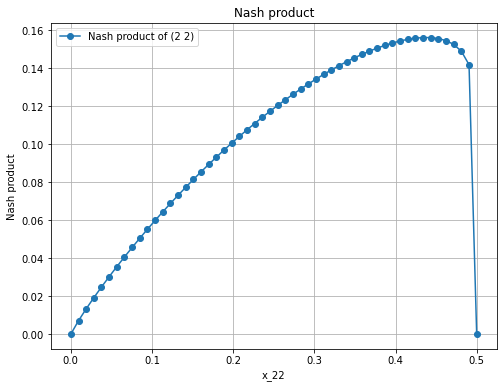

In [30]:
# Nash product of (22)

x = X[3,:]
y = Nash_product_values_22[6,1,11,:]
# Plot the points
plt.figure(figsize=(8, 6))
plt.plot(x, y, 'o-', label='Nash product of (2 2)')  # 
plt.xlabel('x_22')
plt.ylabel('Nash product')
plt.title('Nash product')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
x_22_star_args = np.zeros((1, steps, steps, steps))
x_22_star = np.zeros((1, steps, steps, steps))

for r in range(steps):
        for s in range(steps):
            for t in range(steps):
                x_22_star_args[0,r,s,t] = np.argmax(Nash_product_values_22[r,s,t,:], axis = 0)
                x_22_star[0,r,s,t] = X[3,int(x_22_star_args[0,r,s,t])]
                
print(np.max(x_22_star), np.min(x_22_star))
print("x_22 maps to interior of X:", (np.max(x_22_star) < c_bar and np.min(x_22_star) > x_min))
print(np.unique(x_22_star))

0.4433962264150943 0.43396226415094336
x_22 maps to interior of X: True
[0.43396226 0.44339623]


In [32]:
# Assumption 3.3
print("Assumption 3.3 (F maps into interior of X) holds:", 
      (np.max(x_11_star) < c_bar and np.min(x_11_star) > x_min) * (np.max(x_22_star) < c_bar and np.min(x_22_star) > x_min) * 
      (np.max(x_12_star) < c_bar and np.min(x_12_star) > x_min) * (np.max(x_22_star) < c_bar and np.min(x_22_star) > x_min)
      )

Assumption 3.3 (F maps into interior of X) holds: True


## Jacobi sequence to compute equilibria

In [33]:
#  define the update function

def jacobi_update(x):
    """
    Applies the Jacobi algorithm to function Q, with
            Q(w) = w - F(w)

    Input:
        x (np.array): K-dimensional column vector with all input prices
    
    Output:
        x_jac (np.array): K-dimensional column vector with all input prices
                          updated by the Jacobi algorithm
    """
    x_jac = np.zeros((len(x), 1))
    
    # map indices to the corresponding arrays
    x_star_map = [x_11_star, x_21_star, x_12_star, x_22_star]
    
    for i in range(len(x)):
        x_not = np.delete(x, i, axis=0)  # extract the vector \mathbf{x}_{-(ij)}
        
        # create index vector using broadcasting and np.where
        index_vector = np.array([np.where(X[i, :] == x_not[j])[0][0] for j in range(len(x_not))])
        
        # update x_jac using the pre-mapped array
        x_jac[i, 0] = x_star_map[i][0, index_vector[0], index_vector[1], index_vector[2]]
    
    return x_jac


In [36]:
# check all equilibria
x_11_array = np.array(np.unique(x_11_star))
x_21_array = np.array(np.unique(x_21_star))
x_12_array = np.array(np.unique(x_12_star))
x_22_array = np.array(np.unique(x_22_star))

eqm_counter = np.zeros((1,len(x_11_array) * len(x_21_array) * len(x_12_array) * len(x_22_array)))
print(eqm_counter.shape)

(1, 96)


In [35]:
counter = 0 
for q in range(len(x_11_array)):
    x11 = x_11_array[q]
    for r in range(len(x_21_array)):
        x21 = x_21_array[r]
        for s in range(len(x_12_array)):
            x12 = x_12_array[s]
            for t in range(len(x_22_array)):
                x22 = x_22_array[t]
                x = np.array([x11,x21,x12,x22])
                print(f'{x} is an equilibrium:', (x.reshape(L,)-jacobi_update(x).reshape(L,)).any()==0)
                if (x.reshape(L,)-jacobi_update(x).reshape(L,)).any()==0:
                    eqm_counter[0,counter] = 1
                counter += 1

print('There equilibrium with this grid is unique:', np.sum(eqm_counter == 1) == 1)

[0.33018868 0.27358491 0.36792453 0.43396226] is an equilibrium: False
[0.33018868 0.27358491 0.36792453 0.44339623] is an equilibrium: False
[0.33018868 0.27358491 0.37735849 0.43396226] is an equilibrium: False
[0.33018868 0.27358491 0.37735849 0.44339623] is an equilibrium: False
[0.33018868 0.27358491 0.38679245 0.43396226] is an equilibrium: False
[0.33018868 0.27358491 0.38679245 0.44339623] is an equilibrium: False
[0.33018868 0.27358491 0.39622642 0.43396226] is an equilibrium: False
[0.33018868 0.27358491 0.39622642 0.44339623] is an equilibrium: False
[0.33018868 0.28301887 0.36792453 0.43396226] is an equilibrium: False
[0.33018868 0.28301887 0.36792453 0.44339623] is an equilibrium: False
[0.33018868 0.28301887 0.37735849 0.43396226] is an equilibrium: False
[0.33018868 0.28301887 0.37735849 0.44339623] is an equilibrium: False
[0.33018868 0.28301887 0.38679245 0.43396226] is an equilibrium: False
[0.33018868 0.28301887 0.38679245 0.44339623] is an equilibrium: False
[0.330